In [20]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [17]:
pd.set_option("display.max_columns", None)

In [8]:
# Load the dataset from the CSV file (kaggle) using pandas
file_path = "/Users/dan/git_repo/movs/python/2q/MLOps/ML_piplie_project/creditcard.csv"

df = pd.read_csv(file_path)

# EDA

In [18]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [19]:
p = df.isna().sum().sum()
print(f"Total NaN in Data: {p}")

df.describe()

Total NaN in Data: 0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Most of columns normalized, but not all. I'll use catboost (boosting) - it does not need to normalize the rest of the data

## Target

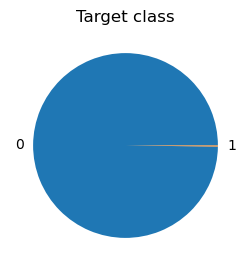

In [27]:
# Target plot
plt.figure(figsize=(3, 3))

df["Class"].value_counts().plot(kind="pie")
plt.title("Target class")
plt.ylabel("")
plt.xlabel("")
plt.show()

In [28]:
# Target counts
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

# Modeling

___prepaid data___

In [41]:
from sklearn.model_selection import train_test_split
from catboost import Pool
from catboost import CatBoostClassifier

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("Class", axis=1),
    df["Class"],
    test_size=0.30,
    random_state=42,
    stratify=df["Class"],
)

In [36]:
# Split test on valid + test
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)

In [39]:
train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_valid, y_valid)

__model__

In [75]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [72]:
# Создаем экземпляр классификатора
params = {
    "verbose": 50,
    "random_seed": 42,
    "learning_rate": 0.008,
    "auto_class_weights": "Balanced",
    #'early_stopping_rounds' : 100,
    "eval_metric": "AUC",
    "loss_function": "Logloss",
}


cb = CatBoostClassifier(**params)

In [73]:
# Обучаем модель на данных в Pool
cb.fit(train_pool, eval_set=valid_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9229536	best: 0.9229536 (0)	total: 21.2ms	remaining: 21.2s
50:	test: 0.9763448	best: 0.9779247 (33)	total: 758ms	remaining: 14.1s
100:	test: 0.9775676	best: 0.9781402 (84)	total: 1.66s	remaining: 14.8s
150:	test: 0.9789713	best: 0.9789713 (150)	total: 2.64s	remaining: 14.8s
200:	test: 0.9786592	best: 0.9794124 (176)	total: 3.58s	remaining: 14.2s
250:	test: 0.9798389	best: 0.9798389 (250)	total: 4.38s	remaining: 13.1s
300:	test: 0.9799038	best: 0.9799422 (259)	total: 5.13s	remaining: 11.9s
350:	test: 0.9808421	best: 0.9808421 (350)	total: 5.97s	remaining: 11s
400:	test: 0.9804653	best: 0.9815047 (368)	total: 6.85s	remaining: 10.2s
450:	test: 0.9804251	best: 0.9815047 (368)	total: 7.69s	remaining: 9.36s
500:	test: 0.9807962	best: 0.9815047 (368)	total: 8.53s	remaining: 8.5s
550:	test: 0.9807952	best: 0.9815047 (368)	total: 9.35s	remaining: 7.62s
600:	test: 0.9797213	best: 0.9815047 (368)	total: 10.2s	remaining: 6.75s
650:	test: 0.9796237	best: 0.9815047 (368)	total: 11s	remain

In [82]:
prediction = cb.predict_proba(X_test)[:, 1]

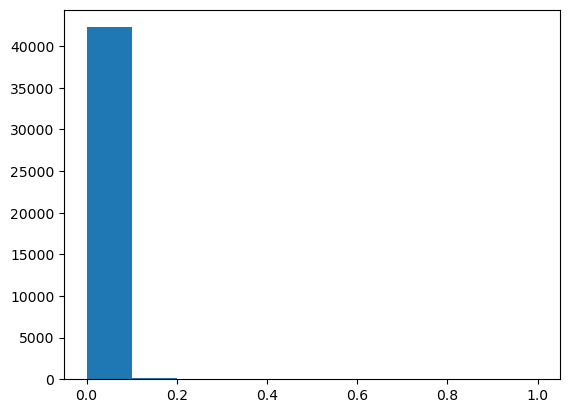

In [85]:
plt.hist(prediction)

plt.show()

In [84]:
roc_auc_score(y_test, prediction)

0.9626223719498903

In [87]:
from sklearn.metrics import confusion_matrix

In [90]:
df_test_metric = pd.DataFrame()
df_test_metric["score"] = prediction
df_test_metric["true"] = y_test.values

In [92]:
import math

In [93]:
df_test_metric["score_bin"] = df_test_metric["score"].apply(lambda x: math.floor(x * 10))

In [102]:
metrics_df = (
    df_test_metric.groupby("score_bin")["true"]
    .agg(["mean", "count", "sum"])
    .reset_index()
)
metrics_df["mean"] = round(metrics_df["mean"] * 100, 2)
metrics_df

,score_bin,mean,count,sum
0,0,0.03,42261,11
1,1,0.00,210,0
2,2,0.00,92,0
3,3,0.00,32,0
4,4,3.85,26,1
5,5,0.00,7,0
6,6,0.00,6,0
7,7,0.00,9,0
8,8,20.00,5,1
9,9,82.43,74,61
